In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src import generator as gen
from src.estimators import SNNEstimator, RidgeEstimator, GapEstimator
from src.general_snn import general_snn
from src import anchor_matrix as am

In [2]:
def print_analytics(RMSEs, MAEs, rating_matrix, Y_restored):
  print(f"RMSE: {np.mean(RMSEs):.4f}±{np.sqrt(np.var(RMSEs)):.3f}")
  print(f"MAE: {np.mean(MAEs):.4f}±{np.sqrt(np.var(MAEs)):.3f}")
  # distribution of true vs restored samples:
  plt.hist(rating_matrix.flatten(), bins=100, alpha=0.3, label="true ratings")
  plt.hist(Y_restored.flatten(), bins=100, color='C0', alpha=0.7, label="restored ratings")
  plt.xlabel('ratings')
  plt.ylabel('frequency')
  plt.grid(alpha=0.5)
  plt.legend()
  plt.legend(loc="upper right");

In [3]:
def run_test(rating_matrix, P, biclique_search, estimator, num_estimates=1, num_runs=1):
    RMSEs = []
    MAEs = []
    for _ in range(num_runs):
        D = np.random.binomial(1, P)
        Y = rating_matrix.copy()
        Y[D == 0] = np.nan
        estimator.prepare(Y, D)
        Y_restored = general_snn(
          D, Y,
          estimator=estimator,
          biclique_search=biclique_search,
          num_estimates=num_estimates,
          min_val=1, max_val=5,
          print_progress=True
        )
        Error = (rating_matrix - Y_restored).flatten()
        RMSEs.append(np.sqrt(np.mean(Error ** 2)))
        MAEs.append(np.mean(np.abs(Error)))

    print_analytics(RMSEs, MAEs, rating_matrix, Y_restored)

In [21]:
inv_scale=1

rating_matrix, P = gen.getRatingAndPropensityMatrix(inv_scale=inv_scale)

### 1.1 Baseline: Best Submatrix, SNN unmodified

 79/80
RMSE: 0.3983±0.000
MAE: 0.2249±0.000


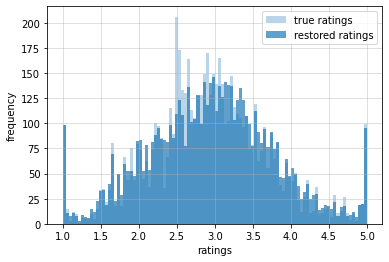

In [5]:
run_test(
  rating_matrix, P,
  biclique_search=am.biclique_find,
  estimator=SNNEstimator(),
  num_estimates=1,
  num_runs=1,
)

### 1.2 Baseline-opt: Best Submatrix, SNN with better params

 79/80
RMSE: 0.1800±0.000
MAE: 0.0414±0.000


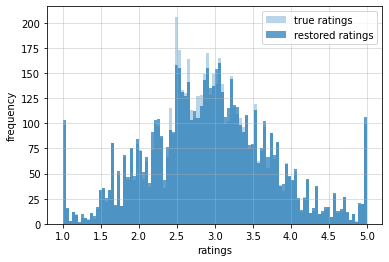

In [10]:
run_test(
  rating_matrix, P,
  biclique_search=am.biclique_find,
  estimator=SNNEstimator(spectral_rank_fun=lambda s, m, n: np.sum(s>=0.001)),
  num_estimates=1,
  num_runs=1,
)

## 2. Randomized solutions

### 2.1 Randomized + SNN

 79/80
RMSE: 0.2261±0.000
MAE: 0.1158±0.000


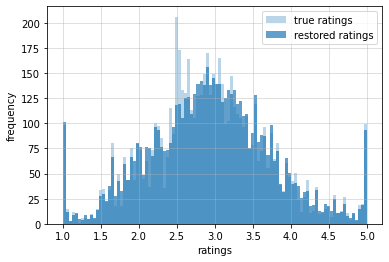

In [8]:
run_test(
  rating_matrix, P,
  biclique_search=am.biclique_random,
  estimator=SNNEstimator(spectral_rank_fun=lambda s, m, n: 4),
  num_estimates=5,
  num_runs=1,
)

### 2.2 Randomized + Ridge

 79/80
RMSE: 0.1226±0.000
MAE: 0.0626±0.000


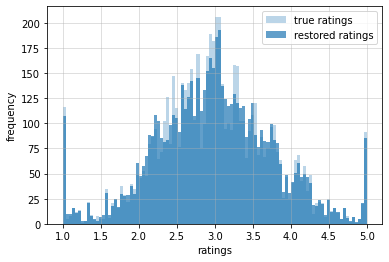

In [11]:
run_test(
  rating_matrix, P,
  biclique_search=am.biclique_random,
  estimator=RidgeEstimator(),
  num_estimates=5,
  num_runs=1,
)

## 3. Gap methods

## 3.1 Gap Method with Ridge Estimator

In [15]:
import importlib
import src.estimators as ests
importlib.reload(ests);

 79/80
 79/80
 79/80
RMSE: 0.0634±0.009
MAE: 0.0331±0.004


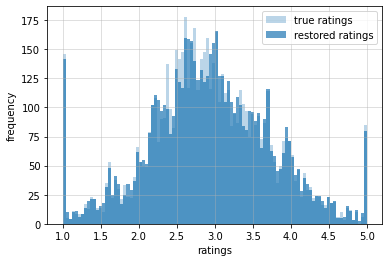

In [24]:
run_test(
  rating_matrix, P,
  biclique_search=am.whole_matrix,
  estimator=ests.GapEstimator(
    estimator=RidgeEstimator(),
    avg_method="column",
    avg_base="submatrix",
  ),
  num_estimates=1,
  num_runs=3,
)

 79/80
 79/80
 79/80
RMSE: 0.0531±0.001
MAE: 0.0276±0.001


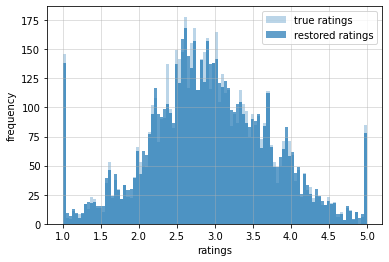

In [25]:
run_test(
  rating_matrix, P,
  biclique_search=am.whole_matrix,
  estimator=ests.GapEstimator(
    estimator=RidgeEstimator(),
    avg_method="column",
    avg_base="complete",
  ),
  num_estimates=1,
  num_runs=3,
)

## 3.2 Gap Method with SNN (with opt parameters)

 79/80
RMSE: 0.1473±0.000
MAE: 0.0577±0.000


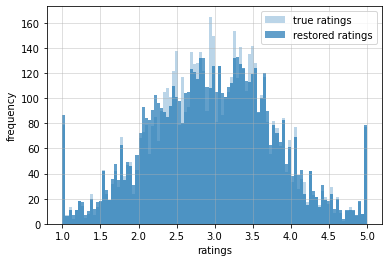

In [11]:
run_test(
  rating_matrix, P,
  biclique_search=am.whole_matrix,
  estimator=GapEstimator(
    avg_method="column",
    estimator=SNNEstimator(spectral_rank_fun=lambda s, m, n: np.sum(s>=0.001))
  ),
  num_estimates=1,
  num_runs=1,
)